# 1. Импорт и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

<Figure size 1500x500 with 0 Axes>

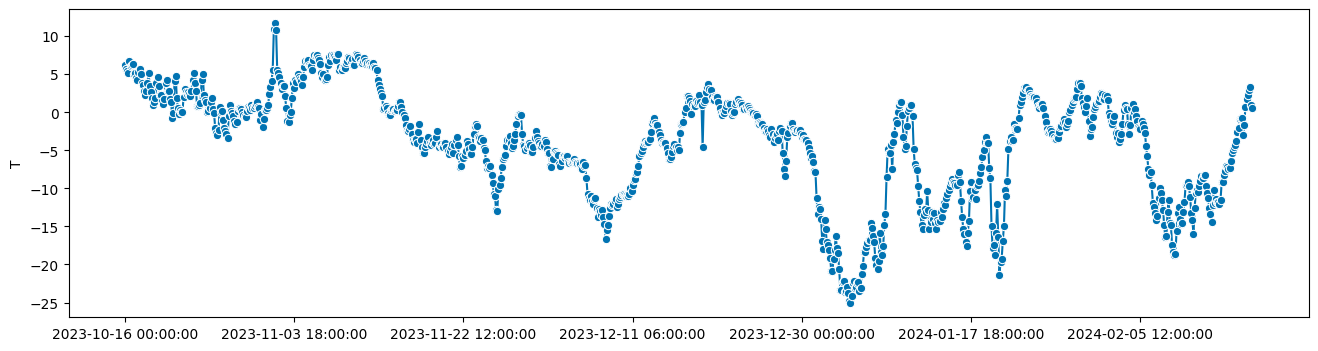

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plot_series(temp[-1000:])
plt.show()

In [2]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return np.sqrt(s / n) 

52504 2920


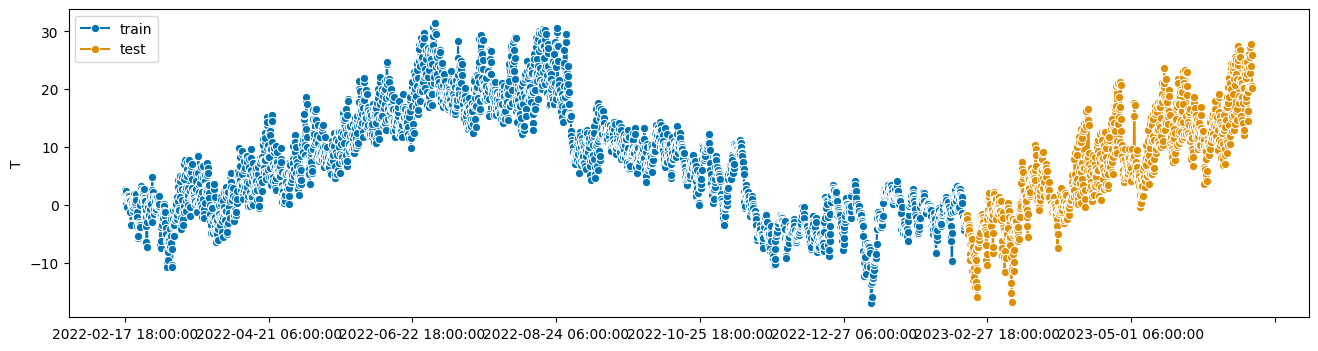

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

temp_train, temp_test = temporal_train_test_split(temp, test_size=2920)
plot_series(temp_train[-2922:], temp_test[:1000], labels=['train', 'test'])
print(temp_train.shape[0], temp_test.shape[0])

In [5]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(temp_test.index, is_relative=False)

# Наивный прогноз

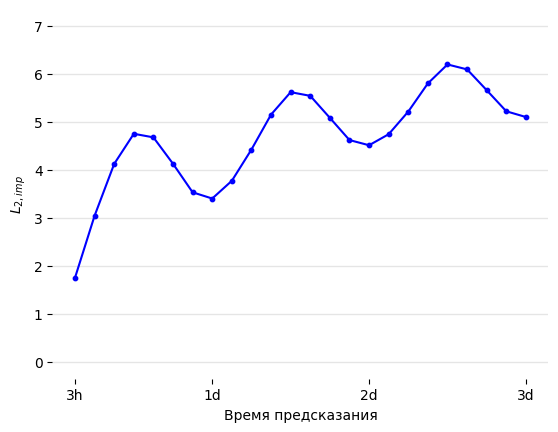

In [5]:
maes = [l2_improved(temp_test[i:].values, temp_test[:-i].values, temp_test.index[i:].hour) for i in range(1, 25)]

import matplotlib.pyplot as plt

x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(8):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, maes, color='blue')
plt.scatter(x_values, maes, color='blue', s=10)
plt.xticks(x_values, names)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.show()

# ETS модель (без тренда) - наивная + сезонность

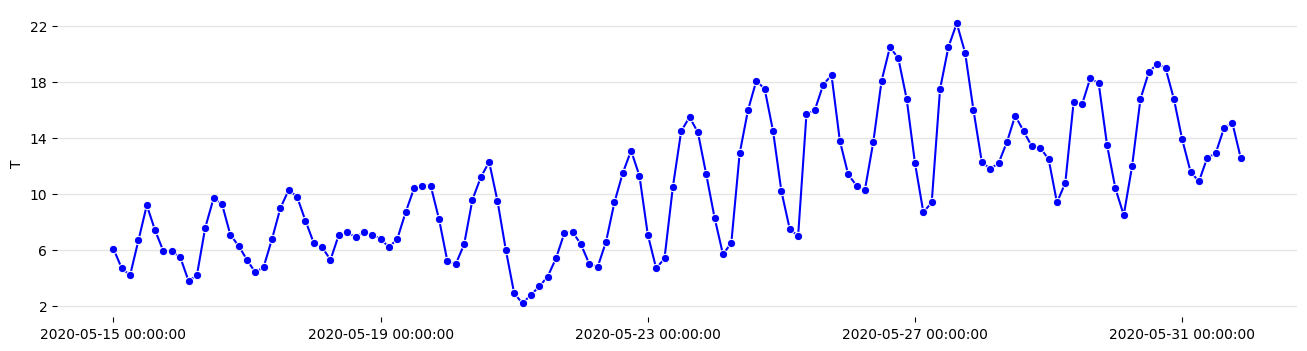

[6.1, 4.7, 4.2, 6.7, 9.2, 7.4, 5.9, 5.9, 5.5, 3.8, 4.2, 7.6, 9.7, 9.3, 7.1, 6.3, 5.3, 4.4, 4.8, 6.8, 9.0, 10.3, 9.8, 8.1, 6.5, 6.2, 5.3, 7.1, 7.3, 6.9, 7.3, 7.1, 6.8, 6.2, 6.8, 8.7, 10.4, 10.6, 10.6, 8.2, 5.2, 5.0, 6.4, 9.6, 11.2, 12.3, 9.5, 6.0, 2.9, 2.2, 2.8, 3.4, 4.1, 5.4, 7.2, 7.3, 6.4, 5.0, 4.8, 6.6, 9.4, 11.5, 13.1, 11.3, 7.1, 4.7, 5.4, 10.5, 14.5, 15.5, 14.4, 11.4, 8.3, 5.7, 6.5, 12.9, 16.0, 18.1, 17.5, 14.5, 10.2, 7.5, 7.0, 15.7, 16.0, 17.8, 18.5, 13.8, 11.4, 10.6, 10.3, 13.7, 18.1, 20.5, 19.7, 16.8, 12.2, 8.7, 9.4, 17.5, 20.5, 22.2, 20.1, 16.0, 12.3, 11.8, 12.2, 13.7, 15.6, 14.5, 13.4, 13.3, 12.5, 9.4, 10.8, 16.6, 16.4, 18.3, 17.9, 13.5, 10.4, 8.5, 12.0, 16.8, 18.7, 19.3, 19.0, 16.8, 13.9, 11.6, 10.9, 12.6, 12.9, 14.7, 15.1, 12.6]


In [6]:
plot_series(temp[-10992:-10856], colors=['blue'])
for h in list(range(2, 23, 4)):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)
plt.box(False)
plt.xticks(list(range(0, 136, 32)))
plt.yticks(list(range(2, 23, 4)))
plt.show()
print(list(temp[-10992:-10856]))

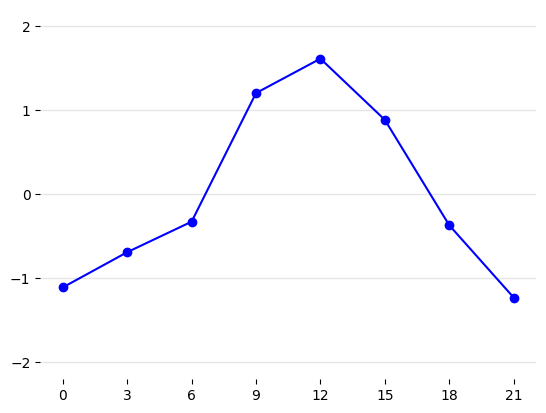

In [17]:
# 52504
day_diff = [np.mean([temp_train.iloc[8 * i + j + 1] - temp_train.iloc[8 * i + j] for i in range(1, 6560)]) for j in range(8)]
plt.box(False)
for h in list(range(-2, 3)):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)
plt.plot(range(0, 22, 3), [day_diff[-1]] + day_diff[:-1], marker='o', color='blue')
plt.xticks(range(0, 22, 3))
plt.yticks(range(-2, 3))
plt.show()

In [53]:
train_frame = temp_train.diff().to_frame()
train_frame['day'] = train_frame.index.dayofyear
year_diff = train_frame.groupby('day')['T'].mean()
year_diff = year_diff.rolling(window=40, min_periods=20, center=True).mean()

<function matplotlib.pyplot.show(close=None, block=None)>

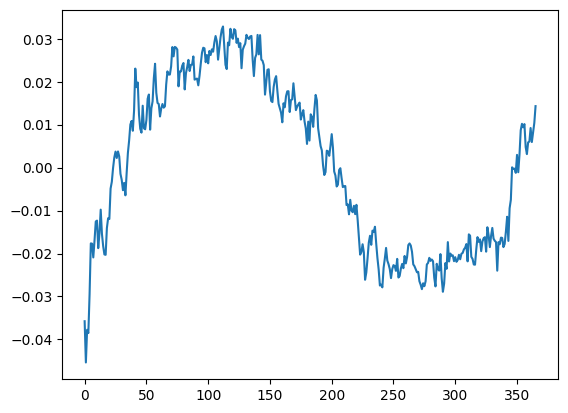

In [54]:
plt.plot(range(len(year_diff)), year_diff)
plt.show

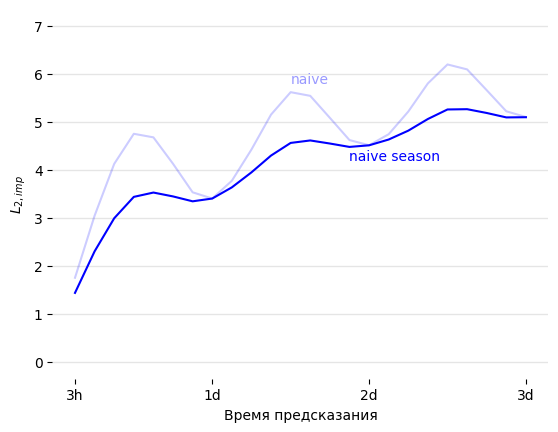

In [62]:
maes_s = []
for i in range(24):
    temp_test_predict = temp_test.values.copy()
    for j in range(len(temp_test_predict) - 24):
        temp_test_predict[j] += sum([day_diff[(j + k) % 8] for k in range(i + 1)]) + sum([year_diff[temp_test.index[j + k].dayofyear] for k in range(7, i, 8)])
    maes_s.append(l2_improved(temp_test_predict[:-(i + 1)], temp_test[(i + 1):].values, temp_test.index[(i + 1):].hour))


import matplotlib.pyplot as plt

x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(8):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, maes, color='blue', alpha=0.2, label='naive')
plt.plot(x_values, maes_s, color='blue', label='naive season')
plt.xticks(x_values, names)
plt.text(14, 4.2, "naive season", color='blue')
plt.text(11, 5.8, "naive", color='blue', alpha=0.4)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.show()